**Meaning Classification with lambeq QNLP Toolkit**

Quantum Pipeline Simulation

This tutorial is based on - https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline_tket.ipynb

**Rewriting with jax**

There are total 130 sentences in the data set where the training set has 70, development set has 30 and test set has 30. There are two kinds of sentences available which are related to either Maths or Music. This is a binary senence classification problem.

**Installing necessary libraries**

**Reading the dataset and storing it in separate variables**

In [1]:
import numpy as np
import warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 120
SEED = 0

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('mm_mc_train_data.txt')
dev_labels, dev_data = read_data('mm_mc_dev_data.txt')
test_labels, test_data = read_data('mm_mc_test_data.txt')

**Parsing the sentences and converting them into string diagrams**

Extracting model...


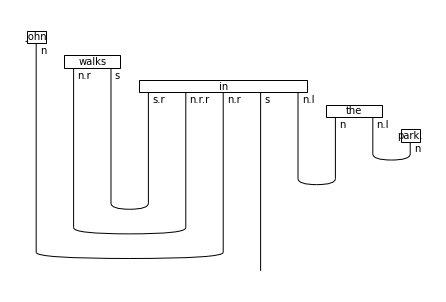

In [2]:
from lambeq import BobcatParser, DepCCGParser
from lambeq import TreeReader, TreeReaderMode
from discopy import grammar

sentence = 'John walks in the park.'
reader = BobcatParser(verbose='text')
reader.sentence2diagram(sentence).draw()

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


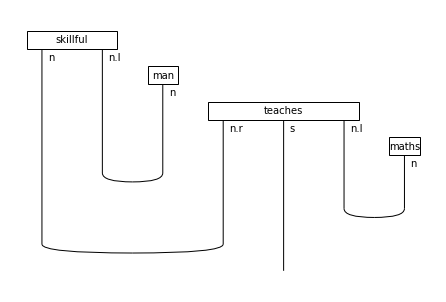

In [3]:
raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)
raw_train_diagrams[0].draw()

**String diagram rewriting**

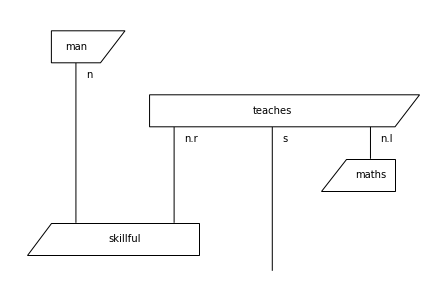

In [4]:
from lambeq import remove_cups
# from discopy.rigid import Id

"""
def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]
            
            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]
"""

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

**Conversion of each diagram into a quantum circuit**

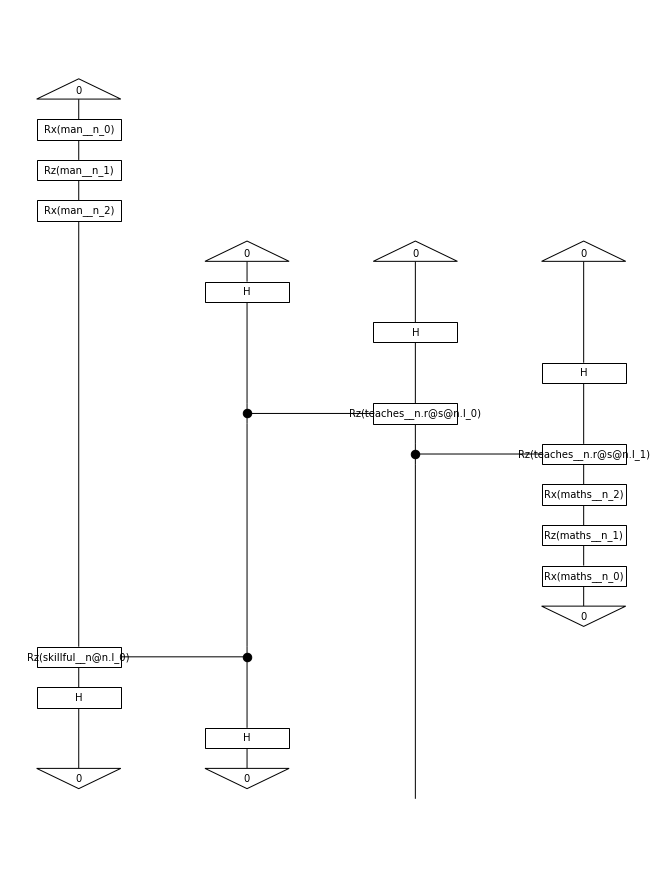

In [5]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

**Parameterise**

In [6]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [7]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [8]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [9]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [10]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 0.6137   valid/loss: 0.7355   train/acc: 0.7429   valid/acc: 0.5667
Epoch 12:   train/loss: 0.4281   valid/loss: 0.2970   train/acc: 0.8857   valid/acc: 1.0000
Epoch 24:   train/loss: 0.3558   valid/loss: 0.3303   train/acc: 0.9286   valid/acc: 0.9667
Epoch 36:   train/loss: 0.2707   valid/loss: 0.2312   train/acc: 1.0000   valid/acc: 1.0000
Epoch 48:   train/loss: 0.2274   valid/loss: 0.1970   train/acc: 1.0000   valid/acc: 1.0000
Epoch 60:   train/loss: 0.2067   valid/loss: 0.1348   train/acc: 1.0000   valid/acc: 1.0000
Epoch 72:   train/loss: 0.2125   valid/loss: 0.1487   train/acc: 1.0000   valid/acc: 1.0000
Epoch 84:   train/loss: 0.1952   valid/loss: 0.1448   train/acc: 1.0000   valid/acc: 1.0000
Epoch 96:   train/loss: 0.1760   valid/loss: 0.1271   train/acc: 1.0000   valid/acc: 1.0000
Epoch 108:  train/loss: 0.1621   valid/loss: 0.0966   train/acc: 1.0000   valid/acc: 1.0000
Epoch 120:  train/loss: 0.1522   valid/loss: 0.1305   train/acc: 1.0000   valid/

Test accuracy: 1.0


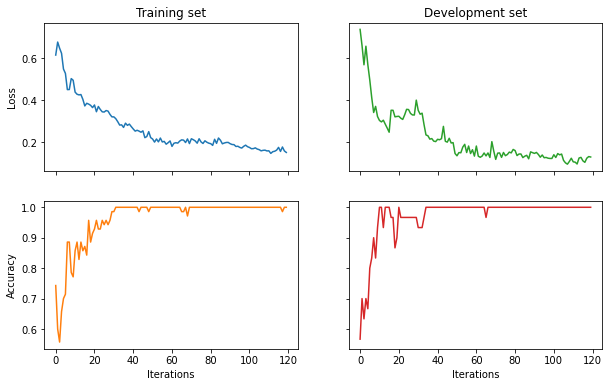

In [11]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)

**Sorting the symbols in quantum circuits to collect the parameters**

**Defining the quantum simulator**

**Making predictions from the quantum circuits**

**Calculating cost function, accuracy and optimizing the circuit parameters**

**Plotting the training & development set results**